# Pump-probe simple analysis example

This is a simple analysis example on how to:

    -load data and corrections for the Alvra 4.5M Jungfrau
    -correct Jungfrau images
    -do some basic analysis and plotting
    -It can be used to loop through files and plot the XAS transient as a function of Energy *OR* Delay

First, you import modules for Numpy (matrix manipulation), H5Py (HDF5 files), matplotlib (plotting) and jungfrau_utils (Jungfrau corrections)

In [15]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import time

In [16]:
#Following lines are to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [17]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17803/res/JF_pedestals/pedestal_20190124_2035.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V01/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

channel_JFimages = "data/JF02T09V01/data"
channel_pulse_idsJF = "data/JF02T09V01/pulse_id"

channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"      #Mono energy in eV
channel_pulse_idsBS = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

#channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
#channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero2 = "data/SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
#channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
#channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
#channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
#channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
#channel_PALM_drift = "data/SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

Dimensions of G:  (4, 512, 9216)


In [18]:
def LoadData_JF(filename):
    with h5py.File(filename, 'r') as JF_file:
        
        pulse_ids = JF_file[channel_pulse_idsJF]
        #pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        #reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        image_JF = JF_file[channel_JFimages]
        
    return pulse_ids,image_JF#reprate_FEL,reprate_laser,image_JF

def LoadData_BS(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_idsBS][:]
        pulse_ids = np.reshape(pulse_ids, (pulse_ids.size,))
        
        #reprate_FEL = ((pulse_ids%10 == 0) & (pulse_ids%20 != 0))              #This is for 10 Hz
        #reprate_laser = pulse_ids%20 == 0                                      #This is for 5 Hz
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]      
        
        delay = BS_file[channel_delay][:][reprate_FEL]
        energy = BS_file[channel_energy][:][reprate_FEL]
        
    return delay, energy, Izero_pump, Izero_unpump

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [19]:
DIR = "/sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012/"
# DIR = "/sf/alvra/data/p17803/raw/"

DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

!ls -lah -t /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012/
# !ls -lah -t /sf/alvra/data/p17803/raw/


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 3.6T
drwxrwsr-x. 112 root p17803  32K Jan 27 13:52 ..
drwxrwsr-x.   2 root p17803  32K Jan 26 09:13 .
-rw-r--r--.   1 root p17803 3.3G Jan 26 09:13 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0049.BSREAD.h5
-rw-r--r--.   1 root p17803  33M Jan 26 09:10 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0049.BSREAD_CA.h5
-rw-r--r--.   1 root p17803  71G Jan 26 09:10 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0049.JF02T09V01.h5
-rw-r--r--.   1 root p17803 3.3G Jan 26 09:08 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0048.BSREAD.h5
-rw-r--r--.   1 root p17803  34M Jan 26 09:05 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0048.BSREAD_CA.h5
-rw-r--r--.   1 root p17803  71G Jan 26 09:04 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0048.JF02T09V01.h5
-rw-r--r--.   1 root p17803 3.3G Jan 26 09:02 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0047.BSREAD.h5
-rw-r--r--.   1 root p17803  34M Jan 26 08:59 CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0047.BSREAD_CA.h5
-rw-r--r--.

ra-c-003.psi.ch
There are 150 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012/


# JF DATA ANALYSIS
Run the following cells to analyse the JF data.
If you want to access the BS data only, open the other notebook (BS_analysis)

In [20]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

# fileName = "XES_8kev_500fs_m1800_007.JF02T09V01.h5"
fileName = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0015.JF02T09V01.h5"
start_time = time.time()

jf_file = h5py.File(DIR + fileName)

print(jf_file)
intermediate_time1 = time.time()
images = jf_file[channel_JFimages]
pulse_ids = jf_file[channel_pulse_idsJF]
print (images.shape)
intermediate_time2 = time.time()
print (round((intermediate_time2 - intermediate_time1),5))

nframes = 100

#nframes=images.shape(0)

total = 0
threshold_low = 3
threshold_high = 8

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
roi = [[0, images.shape[1]], [0, images.shape[2]]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes
jf_file.close()

plt.figure()
plt.imshow(total, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

<HDF5 file "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0015.JF02T09V01.h5" (mode r)>
(8000, 512, 9216)
0.00084


<IPython.core.display.Javascript object>

# Set the ROIs (roi1 & roi2 in pixels) in the next cell

In [21]:
# Ka emission 
roi1 = [[220, 300], [6900, 7100]] # change these numbers, here they are for both crystals1 (up & down) overlapped
#roi1 = [[7030, 7130], [220, 290]]
# Kb emission 
roi2 = [[240, 320], [7750, 7950]] # change these numbers, here they are for both crystals2 (up & down) overlapped

##################################################################

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

# The next cells are for checking an individual file in a scan

In [22]:
#files = ["Kalpha_Fe_foil_8keV_0.1trans_3"]          # you need to change only this name
#files = ["CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0019","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0020","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0022","CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0023"]
scan_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012"
file_name = "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0015"
step_number = 15

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
n_ON = 0
n_OFF = 0

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
numFiles = 1
print ("Processing",numFiles,"files")

jf_file = h5py.File(DIR + file_name + ".JF02T09V01.h5", "r")
print("Processing file %s" % (jf_file))

intermediate_time1 = time.time()
Images = jf_file[channel_JFimages]
pulse_IDs = jf_file[channel_pulse_idsJF]
(pulse_IDs, Images) = LoadData_JF(str(data['scan_files'][step_number][1]))
intermediate_time2 = time.time()

print (np.shape(Images))

reprate_FEL = ((pulse_IDs[:] %4 == 0) & (pulse_IDs[:] %8 != 0))                #This is for 25 Hz
#reprate_laser = pulse_IDs[:] %8 == 0                                       #This is for 12.5 Hz

intermediate_time2 = time.time()
print (round((intermediate_time2 - intermediate_time1),5))


threshold = 2
threshold_low = 3
threshold_high = 8
photon_range = (6, 7)

nframes = pulse_IDs.size

for i in range(100):
#    image2D_roi1 = jf_file[channel_JFimages][i,roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
    
    image2D_roi1 = Images[i,roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
    image2D_roi1 = ju.apply_gain_pede(image2D_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
    image2D_roi1[image2D_roi1 > threshold_low] = 0
    image2D_roi1[image2D_roi1 < threshold_high] = 0
    #image2D_roi1_ON = convert_to_photon_num_range(image2D_roi1_ON) 
    
    if reprate_FEL[i]:
        spectrum_OFF_roi1 += image2D_roi1.sum(axis=0)
        n_OFF +=1
        
    else:
        spectrum_ON_roi1 += image2D_roi1.sum(axis=0)
        n_ON +=1
        
print (n_ON,n_OFF)
print ("Job done! It took",round((time.time() - start_time),5),"seconds to process 1 file")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_scan_info.json
Processing 1 files
Processing file <HDF5 file "CytC_Fe3_XES_timescan_5uJ_288nm_8000eV_012_step0015.JF02T09V01.h5" (mode r)>
(8000, 512, 9216)
17.43172
50 50
Job done! It took 20.68949 seconds to process 1 file


In [23]:
image2D_roi1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
print(Images_ON.shape)

NameError: name 'Images_ON' is not defined

In [ ]:
# Let's check if everything worked out fine, plotting one spectrum for instance the spectra with laser OFF.
# This is for ROI1

x_axis = np.arange(roi1[1][0], roi1[1][1])
plt.figure()

plt.subplot(211)
plt.plot(x_axis,spectrum_OFF_roi1, label="ROI1, Spectra OFF", marker='.')
plt.legend(loc="best")
plt.title(jf_file)
#x_axis = np.arange(roi2[1][0], roi2[1][1])
plt.subplot(212)
#plt.plot(x_axis,spectrum_OFF_roi2,label="ROI2, Spectra OFF",marker='.')
plt.legend(loc="best")

<IPython.core.display.Javascript object>


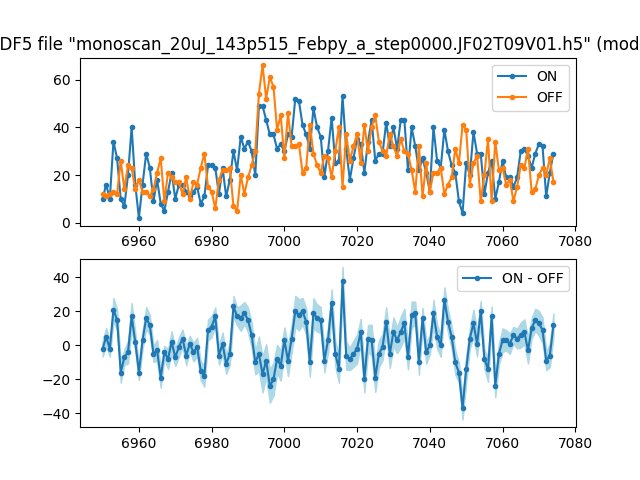

In [15]:
# # # This is for plotting laser on-off spectra from Roi1 to look for pump-probe

spectra_on = spectra_on_roi1.copy()
spectra_off = spectra_off_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

bin_ = 1
spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

In [ ]:
# # # This is for plotting laser on-off spectra from Roi2 to look for pump-probe

spectra_on = spectra_on_roi2.copy()
spectra_off = spectra_off_roi2.copy()
x_axis = np.arange(roi2[1][0], roi2[1][1])

bin_ = 1
spectra_on_rebin2 = rebin_sum(spectra_on)
spectra_off_rebin2 = rebin_sum(spectra_off)
x_axis_rebin2 = rebin_mean(x_axis)

spectra_on_err2=np.sqrt(spectra_on_rebin2)
spectra_off_err2=np.sqrt(spectra_off_rebin2)
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin2,spectra_on_rebin2, label="ON",marker='.')
plt.plot(x_axis_rebin2,spectra_off_rebin2, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)

plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

# The next cell is for looping over several files of a scan. 

In [ ]:
### this is now to loop over SEVERAL FILES
start_time = time.time()

listfile = os.listdir(DIR)
number_files = int(len(listfile)/2)
#number_files = 2

print ("Start processing",number_files,"files")
fileName_root = 'monoscan_20uJ_143p515_Febpy_a'

# Ka emission 
roi1 = [[225, 325], [6950, 7075]] # both crystals overlapped

spectra_on_roi1 = 0
spectra_off_roi1 = 0

n_spectra_on = 0
n_spectra_off = 0

threshold = 2
photon_range = (1, 3)

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

XAS_trans = []
XAS_trans_x = []
Delay_x = []
Error_XAS = []
RIXS_transient = []
Error_transient = []
RIXS_unpumped = []
Error_unpumped = []

for j in range(number_files):
    spectra_on_roi1 = 0
    spectra_off_roi1 = 0
    n_spectra_on = 0
    n_spectra_off = 0
    
    if j < 10:
        fileName = fileName_root + "_step000" + str(j) + ".JF02T09V01.h5"
        fileName_bs = fileName_root + "_step000" + str(j) + ".BSREAD.h5"
    else:
        fileName = fileName_root + "_step00" + str(j) + ".JF02T09V01.h5"
        fileName_bs = fileName_root + "_step00" + str(j) + ".BSREAD.h5"
    jf_file = h5py.File(DIR + fileName, "r")
    bs_file = h5py.File(DIR + fileName_bs, 'r')
    
    Energy_eV = bs_file["data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"]
    Delay_mm = bs_file["data/SLAAR11-LMOT-M451:ENC_1_BS/data"]
    XAS_trans_x.append(Energy_eV[0])
    Delay_x.append(Delay_mm[0])
    
    print("step",j+1,"of",number_files,": Processing %s" % (fileName))
  #   images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["data/JF02T09V01/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0           #-- this is for RepRate 5 (laser)
    #nframes = 10
    nframes = pulse_ids.size
    
    for i in range(nframes):
        image = jf_file["data/JF02T09V01/data"][i,:,:]
        image_roi1 = image[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi1 = ju.apply_gain_pede(image_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_roi1[image_roi1 < threshold] = 0
        image_roi1 = convert_to_photon_num_range(image_roi1)
        
        if laser_on_off[i]:
            spectra_on_roi1 += image_roi1.sum(axis=0)
        
            n_spectra_on += 1

        else:
            spectra_off_roi1 += image_roi1.sum(axis=0)
            
            n_spectra_off += 1
            
    #print('Total images in the file are', nframes)
    
    spectra_on_trans = spectra_on_roi1.copy()
    spectra_on_trans_err = np.sqrt(spectra_on_trans)
    Trans_on = spectra_on_trans.sum()
    Trans_on_err = spectra_on_trans_err.sum()
    
    spectra_off_trans = spectra_off_roi1.copy()
    spectra_off_trans_err = np.sqrt(spectra_off_trans)
    Trans_off = spectra_off_trans.sum()
    Trans_off_err = spectra_off_trans_err.sum()
    
    difference = Trans_on - Trans_off
    spectra_diff = spectra_on_trans - spectra_off_trans
    
    print (n_spectra_on, n_spectra_off, difference)
        
    error_trans_RIXS = np.sqrt(spectra_on_trans_err**2 + spectra_off_trans_err**2)
    error_trans_XAS = np.sqrt(Trans_on_err**2 + Trans_off_err**2)
    
    XAS_trans.append(difference)
    Error_XAS.append(error_trans_XAS)
    RIXS_unpumped.append(spectra_off_trans)
    Error_unpumped.append(spectra_off_trans_err)
    RIXS_transient.append(spectra_diff)
    Error_transient.append(error_trans_RIXS)

XAS_trans_x = np.array(XAS_trans_x)
Delay_x = np.array(Delay_x)
XAS_trans = np.array(XAS_trans)
Error_XAS = np.array(Error_XAS)
RIXS_transient = np.array(RIXS_transient)
Error_transient = np.array(Error_transient)
RIXS_unpumped = np.array(RIXS_unpumped)
Error_unpumped = np.array(Error_unpumped)


print ("Job done! It took",round((time.time() - start_time),2),"seconds to process",number_files,"file(s)")

In [ ]:
error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.title("XAS")
plt.plot(XAS_trans_x, XAS_trans,label="Energy scan",marker='.') #This is the meaningful plot if it is a monoscan
plt.fill_between(np.squeeze(XAS_trans_x), error_low, error_high, color='lightblue')
plt.subplot(122)
plt.title("Delay scan")
plt.plot(Delay_x, XAS_trans,label="Delay scan",marker='.') #This is the meaningful plot if it is a delay scan
plt.fill_between(np.squeeze(Delay_x), error_low, error_high, color='lightblue')


In [ ]:
extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]]

plt.figure()#figsize=(9,8))
plt.subplot(211)
plt.imshow(RIXS_unpumped, aspect = 'auto', cmap = "bwr", origin ="lower")
plt.colorbar()
plt.show()

plt.subplot(212)
plt.imshow(RIXS_transient, aspect = 'auto', cmap = "bwr", origin ="lower")#, vmin=-250, vmax=250)
plt.colorbar()
plt.show()
#fig.savefig('RIXS_unpumped')

In [ ]:
#### This is to save data ####

savedir = "/das/work/p17/p17589/DataAnalysis/"
#savedir = "/das/work/p17/p17569/"

#h5f = h5py.File(savedir + 'test.h5','w') 
h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay_mm_BS', data = Delay_x)
h5f.create_dataset('Energy_BS', data = XAS_trans_x)
h5f.create_dataset('XAS_transient', data = XAS_trans)
h5f.create_dataset('Err_XAS_transient', data = Error_XAS)
h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped)
h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped)
h5f.create_dataset('RIXS_transient', data = RIXS_transient)
h5f.create_dataset('Err_RIXS_transient', data = Error_transient)

h5f.close()

In [ ]:
XAS_trans_x_3ps = XAS_trans_x.copy()
XAS_trans_3ps = XAS_trans.copy()

In [ ]:
plt.figure()
plt.plot(XAS_trans_x_0fs, XAS_trans_0fs,label="t=0 fs", marker='.')
plt.plot(XAS_trans_x_233fs, XAS_trans_233fs,label="t=233 fs", marker='.')
plt.plot(XAS_trans_x_3ps, XAS_trans_3ps,label="t=3.2 ps", marker='.')
plt.legend(loc="best")
plt.title(DIR)

In [ ]:
Delay_5 = Delay_x.copy()
XAS_trans_5 = XAS_trans.copy()

In [25]:
#Delay_ps_4 = (Delay_4 - 143)*3.333
Delay_ps_5 = (Delay_5 - 143)*3.333
#Delay_ps_6 = (Delay_6 - 143)*3.333
#Delay_ps_7 = (Delay_7 - 143)*3.333
#Delay_ps_8 = (Delay_8 - 143)*3.333

error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure()

#plt.plot(Delay_ps_4, XAS_trans_4,label="scan_4", marker='.')
plt.plot(Delay_ps_5, XAS_trans_5,label="scan_5", marker='.')
#plt.plot(Delay_ps_6, XAS_trans_6,label="scan_6", marker='.')
#plt.plot(Delay_ps_7, XAS_trans_7,label="scan_7", marker='.')
#plt.plot(Delay_ps_8, XAS_trans_8,label="scan_8", marker='.')
plt.xlabel("Delay (ps)")
plt.xlim([1, 2.75])

plt.legend(loc="best")
plt.title('All TimeScans, von Hamos')
plt.savefig('Timescans_all_PFY')

NameError: name 'Delay_5' is not defined

In [26]:
Delay_ps_4 = (Delay_4 - 143)*3.333
#Delay_ps_5 = (Delay_5 - 143)*3.333
#Delay_ps_6 = (Delay_6 - 143)*3.333
#Delay_ps_7 = (Delay_7 - 143)*3.333
#Delay_ps_8 = (Delay_8 - 143)*3.333

error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure()

plt.plot(Delay_ps_4, XAS_trans, label="scan_4", marker='.')
#plt.plot(Delay_ps_5, XAS_trans_5,label="scan_5", marker='.')
#plt.plot(Delay_ps_6, XAS_trans_6,label="scan_6", marker='.')
#plt.plot(Delay_ps_7, XAS_trans_7,label="scan_7", marker='.')
#plt.plot(Delay_ps_8, XAS_trans_8,label="scan_8", marker='.')
plt.xlabel("Delay (ps)")
plt.xlim([1, 2.75])

plt.legend(loc="best")
plt.title('All TimeScans, von Hamos')
plt.savefig('Timescans_all_PFY')

NameError: name 'Delay_4' is not defined

In [27]:
print (bs_file)

NameError: name 'bs_file' is not defined